In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [20]:
train_df=pd.read_csv("/kaggle/input/ai-201-b-ese-ai-a/train.csv")
test_df=pd.read_csv("/kaggle/input/ai-201-b-ese-ai-a/test.csv")
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)




train_df.head()


,age,gender,school_type,parent_education,study_hours,attendance_percentage,internet_access,extra_activities,study_method,math_score,science_score,english_score,overall_score,final_grade
0,17.000000,other,public,phd,4.6,51.0,yes,NaN,notes,43.5,48.0,70.6,50.2,e
1,16.000000,other,public,high school,1.1,93.3,NaN,no,online videos,NaN,45.9,51.1,38.5,f
2,14.000000,female,public,no formal,2.7,87.1,yes,NaN,online videos,NaN,48.8,53.8,46.9,e
3,16.000000,other,private,graduate,4.6,69.6,yes,yes,NaN,50.3,49.0,61.7,61.6,NaN
4,5.758603,female,public,high school,NaN,89.1,yes,NaN,NaN,49.8,52.2,NaN,62.9,d


In [21]:
print(train_df.isnull().sum())

X=train_df.drop(columns=["final_grade","gender","school_type","parent_education","internet_access","extra_activities","study_method"])
y=train_df["final_grade"]

age                      1077
gender                   1805
school_type              1540
parent_education         1380
study_hours               779
attendance_percentage     792
internet_access           681
extra_activities         1661
study_method             1337
math_score               1439
science_score             629
english_score            1787
overall_score            1627
final_grade               830
dtype: int64


In [22]:
le=LabelEncoder()
y_encoded=le.fit_transform(y)

print(le.classes_)

['a' 'b' 'c' 'd' 'e' 'f' nan]


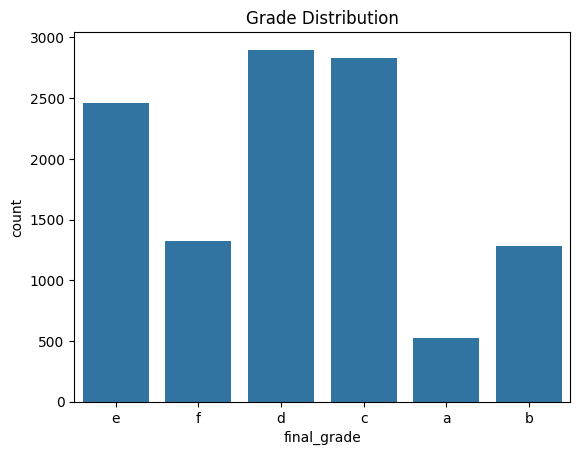

In [23]:
sns.countplot(x=y)
plt.title("Grade Distribution")
plt.show()

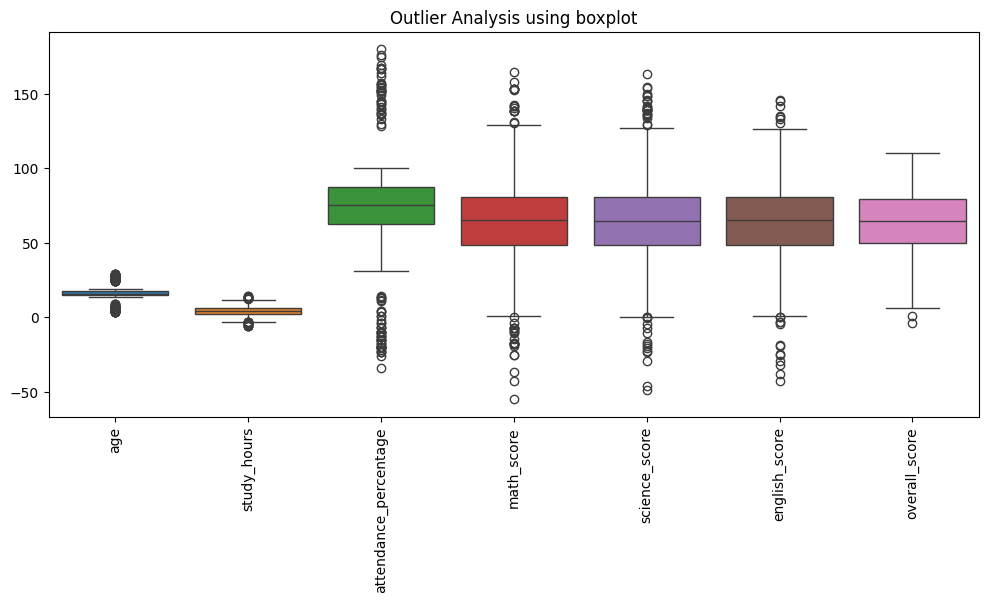

In [24]:
plt.figure(figsize=(12,5))
sns.boxplot(data=train_df.drop(columns=["final_grade"]))
plt.xticks(rotation=90)
plt.title("Outlier Analysis using boxplot")
plt.show()

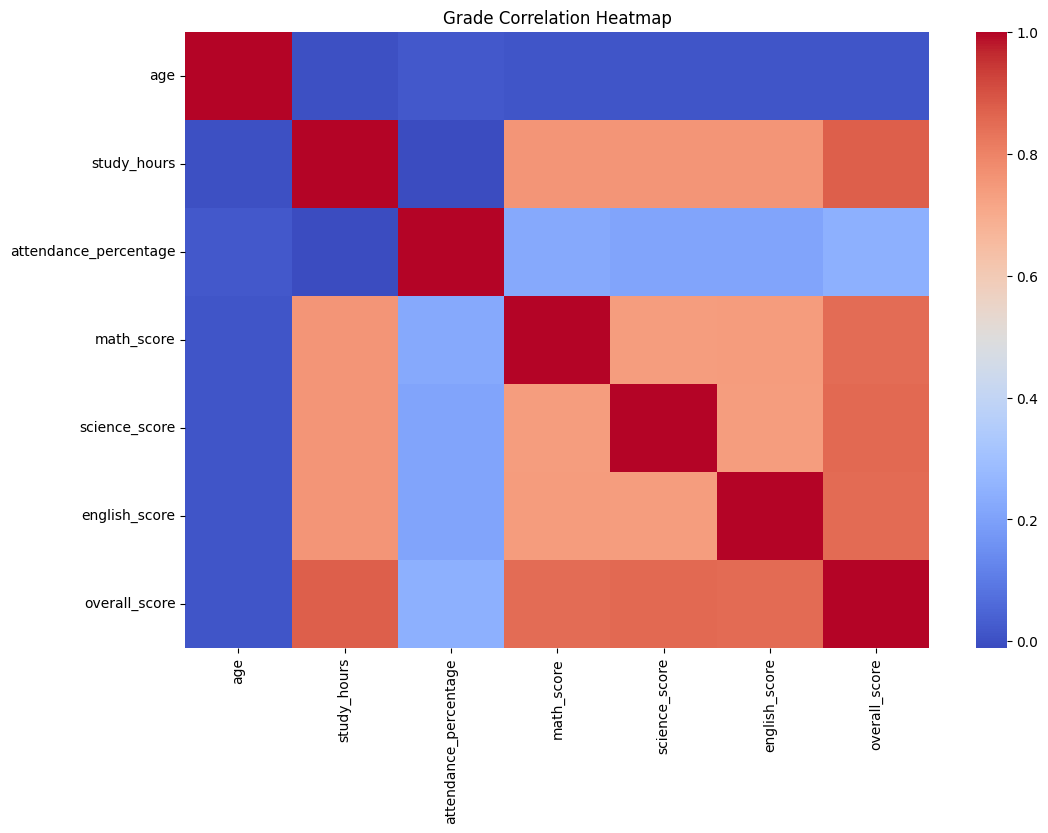

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(train_df.drop(columns=["final_grade","gender","school_type","parent_education","internet_access","study_method","extra_activities"]).corr(), cmap="coolwarm")
plt.title("Grade Correlation Heatmap")
plt.show()

In [26]:
X_train,X_val,y_train,y_val=train_test_split(X,y_encoded, test_size=0.2 , random_state=42, stratify=y_encoded)

In [27]:
pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

In [28]:
param_grid={
    "rf__n_estimators":[100,200],
    "rf__max_depth":[None,10,20],
    "rf__min_samples_split":[2,5],
    "rf__min_samples_leaf":[1,2]
}

grid=GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
grid.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='accuracy')

In [29]:
best_model=grid.best_estimator_
y_pred=best_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val,y_pred))
print("\nclassfication report:", classification_report(y_val,y_pred))

Accuracy: 0.9058000822706705

classfication report:               precision    recall  f1-score   support

           0       0.93      0.95      0.94       104
           1       0.90      0.94      0.92       257
           2       0.91      0.95      0.93       567
           3       0.88      0.99      0.93       580
           4       0.92      0.95      0.93       493
           5       0.94      0.97      0.96       264
           6       0.96      0.13      0.23       166

    accuracy                           0.91      2431
   macro avg       0.92      0.84      0.83      2431
weighted avg       0.91      0.91      0.89      2431



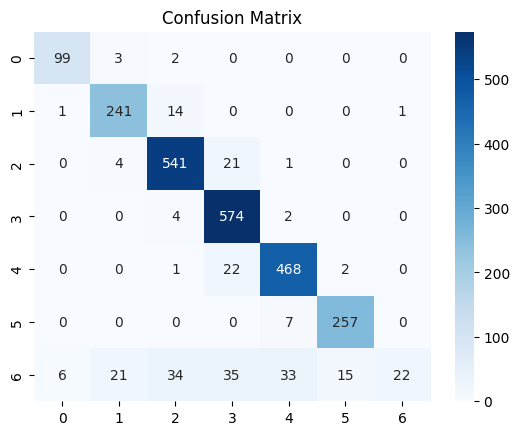

In [30]:
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [33]:
best_model.fit(X, y_encoded)

X_test = test_df.drop(columns=["id","gender","school_type","parent_education","internet_access","extra_activities","study_method"])
test_preds_encoded = best_model.predict(X_test)

test_preds = le.inverse_transform(test_preds_encoded)


In [34]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "Class": test_preds
})

submission.to_csv("submission.csv", index=False)
submission.head()

,id,Class
0,1,d
1,2,f
2,3,e
3,4,c
4,5,c
